<font size=7> HC328 Buzsaki Latencies

# Import stuff, get data

I attempt to get Sury's code for analyzing connectivity working.

In [1]:
from scipy.ndimage import gaussian_filter1d

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import math
from scipy.sparse import csr_array
import random

import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies

In [3]:
#sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip" )
sd = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_2.zip")


# <font color="grey"> Helper Code


Code is adapted from `latencies.py` in the `src` folder

## <font color="grey"> latencies

In [4]:

import numpy as np
from scipy.signal import correlate, correlation_lags



def latencies(neuron1, neuron2, sd, ms_cutoff_low=0, ms_cutoff_high=20 ):
    """
    Function:
        returns all the latencies that occur between two neurons, n1 and n2. 
        A latency is defined as the time difference between a spike from n1 and the nearest spike from n2 (positive or negative)
    Inputs:
        neuron1 (integer): index of the neuron, n1 
        neuron2 (integer): index of the neuron, n2, *note* if n1 occurs before n2, the latency will be positive
        sd (SpikeData object): contains the original spike data from the recording
        ms_cutoff (integer): the maximum latency to be considered, in milliseconds
    Outputs:
        cur_latencies (np.array): the time difference between n1 and n2, for ever latency occurence less than ms_cutoff
    """
    train1 = sd.train[ neuron1 ]
    train2 = sd.train[ neuron2 ]    
    cur_latencies = []
    for time in train1:
        abs_diff_ind = np.argmin(np.abs(train2 - time))  # Subtract time from all spikes in the train and take the absolute value        
        latency = np.array(train2)-time       # Calculate the actual latency
        latency = latency[abs_diff_ind]

        if np.abs(latency) <= ms_cutoff_high and np.abs(latency) >= ms_cutoff_low : # Only append latencies within a certain time cutoff
            cur_latencies.append(latency)
    return np.array(cur_latencies)



## <font color="grey"> Cross Sttc

<font color="orange">I change the original code to calculate the cross sttc from -50-50ms instead of -1000-1000ms. This is done to speed up the calculation.

In [5]:

def cross_sttc( n1, n2, sd, delt=20 ):
    """
    Function: Calculates the cross correlation from -1000ms to 1000ms, expcept using the spike time tiling coefficient, between two neurons, n1 and n2
    Inputs:
        n1 (integer): index of the neuron, n1 
        n2 (integer): index of the neuron, n2
        sd (SpikeData object): contains the original spike data from the recording
        delt (integer): the time window to calculate the spike time tiling coefficient over
    Outputs:
        sttc (float): the spike time tiling coefficient for each shift between n1 and n2
    """
    assert len(sd.neuron_data[0]) == len(sd.train) 
    sttcs = []
    for i in range(-30,31):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)


## <font color="grey"> Cross Correlation

In [6]:

def correlation(x, y):
    """
    Function: Calculates the correlation between two lists
    Inputs:
        x (list): first list
        y (list): second list
    Outputs:
        (float): correlation between x and y
    """
    shortest = min( len(x), len(y) )
    return np.corrcoef(x[:shortest], y[:shortest])[0, 1]


## <font color="grey">Poission Probability <small> Sury Code

Probability of computing n or more event given lambda_

<font color="orange"> I have to still check that Sury's code is correct

In [7]:
def p_fast(n, lambda_):
    """
    A poisson estimation of the probability of observing n or more events
    """
    ## take log to make sure the factorial does not overflow
    # add poisson_var when x = 0, 1, take log after calculation to avoid log(0)
    if n > 1:
        poisson_01 = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in [0, 1]]
        poisson_res = [np.exp(-lambda_ + x*math.log(lambda_) - math.log(math.factorial(x))) for x in range(2, n)]
        poisson_var = poisson_01 + poisson_res
    else:
        poisson_var = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in range(n)]
    continuity_correction = np.exp((math.log(0.5) - lambda_ + n*math.log(lambda_)) - math.log(math.factorial(n)))
    return 1 - np.sum(poisson_var) - continuity_correction


# Initial Curation

code is from `curate_latencies` function

In [11]:
pairs = pickle.load( open( "sanity_20minlates.pkl", "rb" ) )
# sttc_cutoff = 0.04
# latency_cutoff=1
# sttc_delta=20 

# # Get all latencies whose STTC is above some minimum STTC cuttoff
# print(sd.N**2 , "Starting Pairs")
# sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
# pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
# for i in range(sd.N):
#     for j in range(i+1,sd.N):
#         if sttc_neo[i,j] > sttc_cutoff:
#             pairs.append([i,j])
# print( len(pairs), "pairs above sttc cutoff")

# # Get all latencies whose median latency is above some minimum Latency Cuttoff
# pairs_late = [] #lags_late = []
# for pair in pairs:
#     pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
#     if abs(np.median(pair_latencies))> latency_cutoff and len(pair_latencies)>20:
#         if np.median(pair_latencies) < 0:
#             pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
#         else:
#             pairs_late.append( pair )
# pairs= pairs_late
# print( len(pairs_late), "pairs above latencency cutoff")





In [10]:
#pickle.dump( pairs, open( "sanity_20minlates.pkl", "wb" ) )
#pairs = pickle.load( open( "sanity_20minlates.pkl", "rb" ) )

# Buzsaki Method

<font color="orange"> Original paper only considered lags between 0.8-2.8ms. We consider broader range

<font color="red"> Start by doing function for 1 pair

In [13]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

In [14]:
pairs_pois = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_8044/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_8044/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [24]:
len(pairs_pois)
#pairs_pois

826

In [19]:
to_keep = random.sample(range(len(pairs_pois)), 250)

In [20]:
pairs_good = pairs_pois[to_keep]

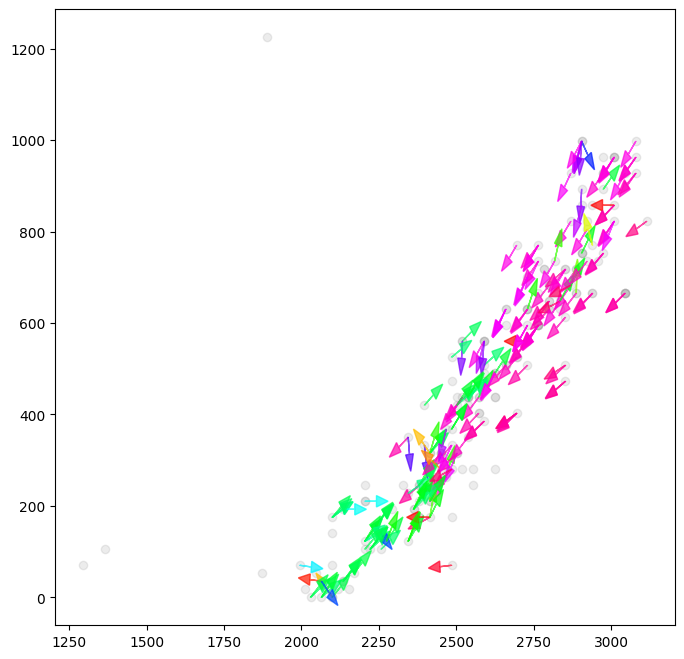

In [28]:
plot_vector_layout( sd, np.array(pairs_good) )

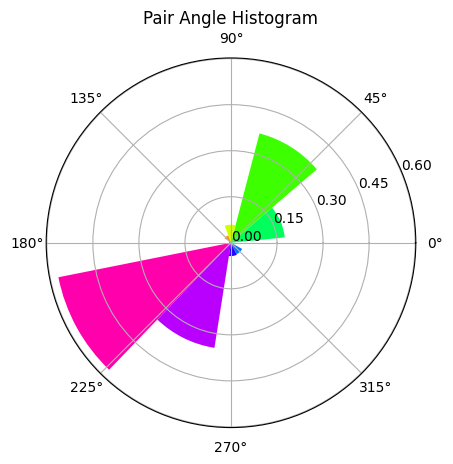

In [22]:
plot_latency_angle_hist(sd, pairs_good , by_firing_rate=True)

# Buzsaki - Anticausal

In [23]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

In [26]:
pairs = pairs_pois

In [27]:
pairs_pois = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois.append( pair )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_8044/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_8044/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [28]:
len(pairs_pois)

2392

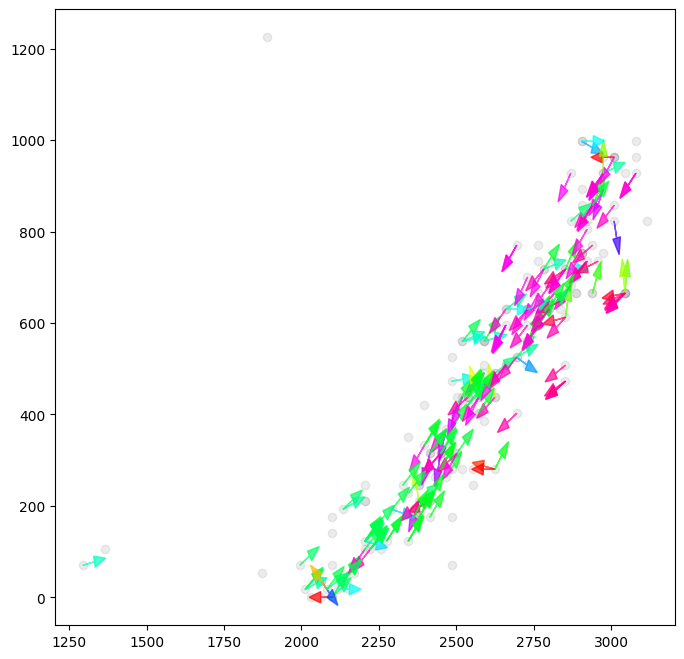

In [29]:
to_keep = random.sample(range(len(pairs_pois)), 200)
plot_vector_layout( sd, pairs_pois[to_keep] )

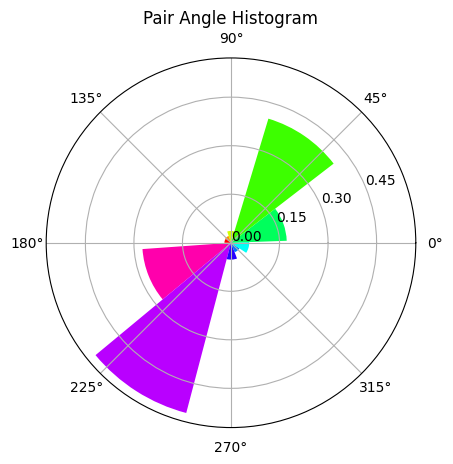

In [30]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)

# <font color="aqua"> Buszaki with Pearson Correlation

In [91]:
len(pairs)

360

<font color="green"> Code to change

In [89]:
smoothness = 1
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=4

In [94]:
pairs_pois = []
for pair in pairs:

    correlations = []
    n2 = np.zeros( int(sd.length)+ 31 )
    n2[ np.round(sd.train[pair[1]]).astype(int) ] = 1
    if smoothness:
        n2 = gaussian_filter1d(n2, sigma=smoothness)  
    for i in range(-30,31):
        n1 = np.zeros( int(sd.length)+ 31 )
        n1[ np.round(sd.train[pair[0]]+i).astype(int) ] = 1
        if smoothness:
            n1 = gaussian_filter1d(n1, sigma=1) 
        correlations.append( np.corrcoef( n1, n2 )[0, 1] )
    correlations_smth = gaussian_filter1d(correlations, sigma=10)

    correlations_cutoff = correlations[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(correlations_cutoff == np.amax(correlations_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = correlations_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.01:
        pairs_pois.append( pair )
        
pairs_pois = np.array(pairs_pois)

ValueError: math domain error

<font color="red"> Start with one pair to figure out cross correlation

In [53]:
pair = pairs[0]
#sd.train
#max(sd.train[0])

In [98]:
len(pairs_pois)

262

In [77]:
correlations = []
n2 = np.zeros( int(sd.length) )
n2[ np.round(sd.train[pair[1]]).astype(int) ] = 1
#n2 = gaussian_filter1d(n2, sigma=2)  
n2 = gaussian_filter1d(n2, sigma=1)  


for i in range(-30,31):
    n1 = np.zeros( int(sd.length) )
    n1[ np.round(sd.train[pair[0]]+i).astype(int) ] = 1
    #n1 = gaussian_filter1d(n1, sigma=2)  
    n1 = gaussian_filter1d(n1, sigma=1) 
    correlations.append( np.corrcoef( n1, n2 )[0, 1] )



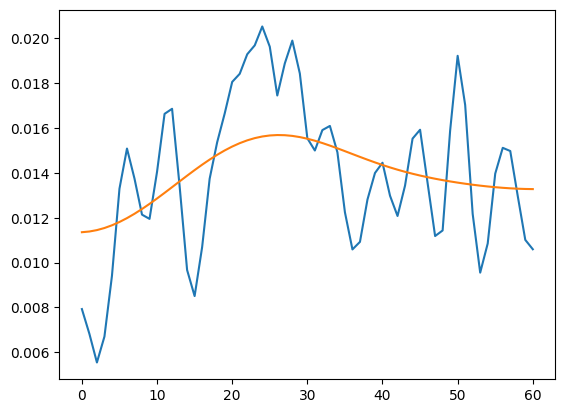

In [78]:
plt.plot(correlations)
correlations_smth = gaussian_filter1d(correlations, sigma=10) 
plt.plot(correlations_smth)

In [79]:
correlations_cutoff = correlations[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
max_arg_cutoff = np.argwhere(correlations_cutoff == np.amax(correlations_cutoff))[0][0] 
pois_n = max_arg_cutoff+cross_sttc_min_cutoff
max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
pois_lambda = correlations_smth[max_arg]
p_val = p_fast(pois_n, pois_lambda)
#if p_val < 0.0005:
#    pairs_pois.append( pair )



In [80]:
p_val

2.91377279813213e-07

In [30]:
sd_raster =  sd.raster(bin_size=1)

In [5]:
sd.length

385238.05

array([0, 0, 0, ..., 0, 0, 0])

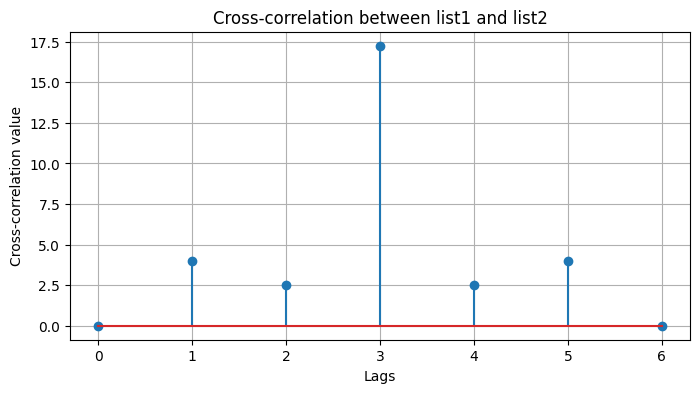

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define your lists
list1 = [0, 1, 0.5, 4]
list2 = [0, 1, 0.5, 4]

# Compute cross-correlation
cross_corr = np.correlate(list1, list2, mode='full')

# Plotting the cross-correlation
plt.figure(figsize=(8, 4))
plt.stem(range(len(cross_corr)), cross_corr )  # Using stem plot for discrete data #use_line_collection=True
plt.title('Cross-correlation between list1 and list2')
plt.xlabel('Lags')
plt.ylabel('Cross-correlation value')
plt.grid(True)
plt.show()

In [28]:
n1 = sd_raster[0]

385239

In [29]:
pair

[0, 1]